In [ ]:
import ee
import geemap
import xarray as xr

In [ ]:
!pip install  xee
import xee


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.2 MB/s eta 0:00:00


In [ ]:
ee.Authenticate()
ee.Initialize(
    project = 'ee-lavibas23',
    opt_url = 'https://earthengine-highvolume.googleapis.com'
)


In [ ]:
# Define the ROI as a Polygon (Sinharaja / Weweltalawa region)
coordinates = [
    [80.4224, 6.3895],
    [80.5408, 6.3895],
    [80.5408, 6.4911],
    [80.4224, 6.4911],
    [80.4224, 6.3895]
]
roi = ee.Geometry.Polygon([coordinates])

# Create a map centered on the ROI
Map = geemap.Map(basemap = 'SATELLITE')
Map.centerObject(roi, zoom=11)

# Add ROI to the map
Map.addLayer(roi, {'color': 'blue'}, 'ROI - Sinharaja Wet Zone')

# Display the map
Map


Map(center=[6.440301714125462, 80.48160000000031], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
pr = (
    ee.ImageCollection("NASA/GPM_L3/IMERG_MONTHLY_V07")
    .select('precipitation')
    .filterDate('2000', '2025')

)

pr

In [ ]:
ds = xr.open_dataset(
    pr,
    engine = 'ee',
    scale = 0.001,
    crs = 'EPSG:4326',
    geometry = roi
)

In [ ]:
ds = ds * 730.0

ds

<xarray.Dataset> Size: 14MB
Dimensions:        (time: 300, lon: 118, lat: 102)
Coordinates:
  * time           (time) datetime64[ns] 2kB 2000-01-01 ... 2024-12-01
  * lon            (lon) float64 944B 80.42 80.42 80.42 ... 80.54 80.54 80.54
  * lat            (lat) float64 816B 6.39 6.391 6.392 ... 6.489 6.49 6.491
Data variables:
    precipitation  (time, lon, lat) float32 14MB 92.71 92.71 ... 130.7 130.7
Attributes:
    crs:      EPSG:4326

In [ ]:
point = ds.sel(
    lon = 80.48,
    lat = 6.44,
    method = 'nearest'
)

point

<xarray.Dataset> Size: 4kB
Dimensions:        (time: 300)
Coordinates:
  * time           (time) datetime64[ns] 2kB 2000-01-01 ... 2024-12-01
    lon            float64 8B 80.48
    lat            float64 8B 6.44
Data variables:
    precipitation  (time) float32 1kB 88.33 193.5 136.5 ... 238.0 263.5 132.1
Attributes:
    crs:      EPSG:4326

In [ ]:
df = point.to_dataframe()['precipitation'].reset_index()

df

,time,precipitation
0,2000-01-01,88.330002
1,2000-02-01,193.450012
2,2000-03-01,136.510010
3,2000-04-01,123.370010
4,2000-05-01,124.099998
...,...,...
295,2024-08-01,162.060013
296,2024-09-01,140.889999
297,2024-10-01,237.980011
298,2024-11-01,263.530029


In [ ]:
from sklearn.cluster import KMeans

In [ ]:
model = KMeans(
    n_clusters = 4,
    random_state = 42
)

In [ ]:
df['class'] = model.fit_predict(df[['precipitation']])
df

,time,precipitation,class
0,2000-01-01,88.330002,1
1,2000-02-01,193.450012,3
2,2000-03-01,136.510010,3
3,2000-04-01,123.370010,3
4,2000-05-01,124.099998,3
...,...,...,...
295,2024-08-01,162.060013,3
296,2024-09-01,140.889999,3
297,2024-10-01,237.980011,0
298,2024-11-01,263.530029,0


In [ ]:
df_index = df.set_index('time')
df_index


,precipitation,class
time,,
2000-01-01,88.330002,1
2000-02-01,193.450012,3
2000-03-01,136.510010,3
2000-04-01,123.370010,3
2000-05-01,124.099998,3
...,...,...
2024-08-01,162.060013,3
2024-09-01,140.889999,3
2024-10-01,237.980011,0


In [ ]:
df_index.groupby('class').describe()

precipitation                                                 \
              count        mean        std         min         25%   
class                                                                
0              62.0  256.936462  32.996067  211.700012  232.322514   
1              88.0   79.586594  28.433939   21.170000   54.202503   
2              35.0  405.275177  61.895596  336.530029  363.905014   
3             115.0  165.697327  24.720930  122.640007  143.080002   

                                           
              50%         75%         max  
class                                      
0      250.755013  279.407509  325.580017  
1       87.235004  101.470009  121.910011  
2      397.120026  423.035034  583.270020  
3      168.630005  186.515007  206.590012

In [ ]:
label = {
    0: 'heavy',
    1: 'moderate',
    2: 'high',
    3: 'low'
}


In [ ]:
df_index['label']  = df_index['class'].map(label)

In [ ]:
import pandas as pd

In [ ]:
df_index

df_index.to_csv('pr_dataset.csv')


In [ ]:
colors = {
    'heavy': 'red',
    'high': 'orange',
    'moderate': 'green',
    'low': 'blue'
}


In [ ]:
import matplotlib.pyplot as plt

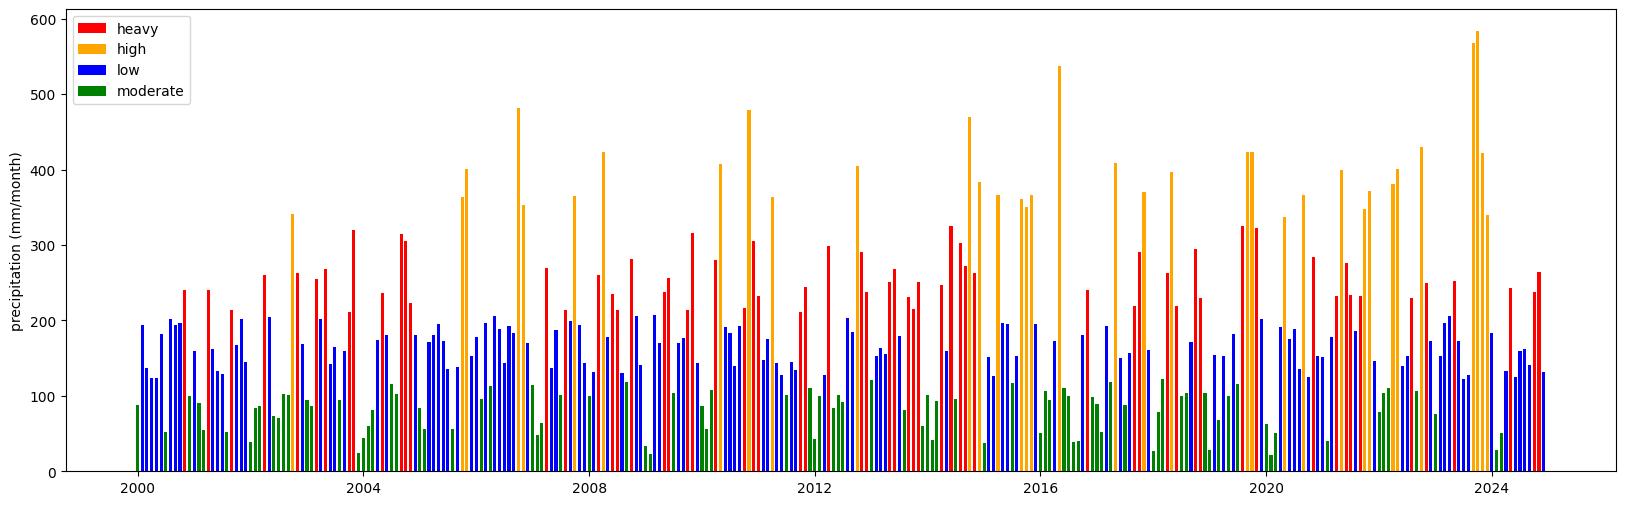

In [ ]:
fig, ax = plt.subplots(figsize = (20, 6))

for label, group in df_index.groupby('label'):
  ax.bar(
      group.index,
      group.precipitation,
      label = label,
      width = 20,
      color = colors.get(label)
  )

ax.legend(loc = 'upper left')
ax.set_ylabel('precipitation (mm/month)')

plt.savefig('pr_clustering.png', dpi = 360, bbox_inches = 'tight')